In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

# Principle component analysis

#### 1) Loading trajectory

We will compute PCA across all dimensions of all atoms, so we can reshape the timesteps, atoms, physical dimension shape into timesteps, all coordinates.

In [2]:
def load_traj(filename):
    if filename.split('.')[-1] == 'npy':
        return np.load('trajectory_calpha.npy')
    else:
        with open(filename, "r") as f:
            docu = f.read()
        frames = docu.split("128\n generated by VMD\n  ")[1:]
        
        columns_names = ['type', 'x', 'y', 'z']
        dfs = [pd.read_csv(StringIO(f), names=columns_names, delim_whitespace=True, header=None) for f in frames]
        arrays = [df[['x','y','z']].values for df in dfs]
    return np.stack(arrays)

In [3]:
traj = load_traj("trajectory_calpha.npy")
print(traj.shape)

# We are trying to find an optimal coordinate projection. Therefore, we can drop the cartesian structure.
traj = traj.reshape(traj.shape[0], -1)
print(traj.shape)

(3111, 128, 3)
(3111, 384)


#### 2) Mean-free trajectory

In [4]:
mean_free_traj = traj - np.mean(traj, axis=0)

#### 3) Covariance matrix

In [5]:
t_n = mean_free_traj.shape[0]
cov = (t_n - 1)**-1 * np.einsum('ij,ik', mean_free_traj, mean_free_traj)  # sum over rows, multiply columns
print(cov.shape)

(384, 384)


In [6]:
# compare to cov
print(np.all(np.isclose(np.cov(mean_free_traj, rowvar=False), cov)))

True


#### 4) Eingenvalues and eigenvectors

In [7]:
evals, evecs = np.linalg.eig(cov)

Text(0.5, 0, 'Eigenvalue rank')

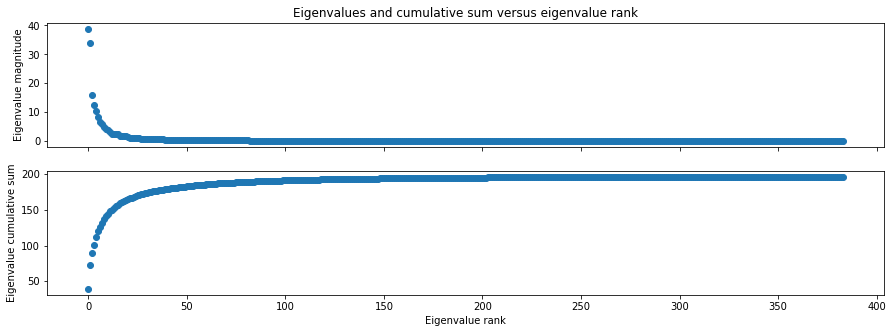

In [8]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15,5))
ax[0].scatter(range(len(evals)), evals)
ax[1].scatter(range(len(evals)), np.cumsum(evals))

ax[0].set_title('Eigenvalues and cumulative sum versus eigenvalue rank')
ax[0].set_ylabel('Eigenvalue magnitude')
ax[1].set_ylabel('Eigenvalue cumulative sum')
ax[1].set_xlabel('Eigenvalue rank')

#### 5) Projection

In [11]:
new = evecs.T @ mean_free_traj.T
print(f"(time, space) = {new.shape}")

(time, space) = (384, 3111)


In [13]:
np.mean(new, axis=0)[:2]

array([-0.03443185, -0.05883051])

#### 6) Visualization

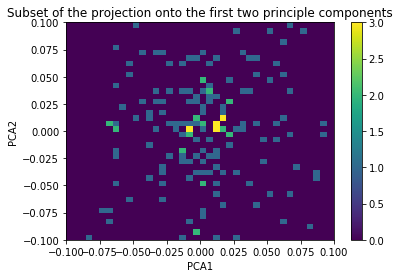

In [126]:
array = np.histogram2d(new[:, 0], new[:, 1])
plot = plt.hist2d(new[:,0],new[:,1], bins = 40, range=((-0.1,0.1),(-0.1,0.1)))
plt.colorbar()
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Subset of the projection onto the first two principle components')
plt.show()

#### 7) Which molecular structure corresponds with the highest maximum?

In [129]:
ind = np.argmax(plot[0])
inds2d = np.unravel_index(ind, plot[0].shape)
xbin = plot[1]
ybin = plot[2]
PCA1_min = xbin[inds2d[0]]
PCA1_max = xbin[inds2d[0] + 1]
PCA2_min = ybin[inds2d[1]]
PCA2_max = ybin[inds2d[1] + 1]

In [130]:
times = []
for i, t in enumerate(new): 
    if PCA1_min < t[0] and t[0] < PCA1_max:
        if PCA2_min < t[1] and t[1] < PCA2_max:
            times.append([i, t])
            
print(times)

[[313, array([-0.00814918,  0.00440533,  0.02193689, ..., -0.00890473,
       -0.04047008,  0.03285583])], [328, array([-0.00546644,  0.00121899,  0.04211118, ..., -0.00388769,
       -0.01698155,  0.01184682])], [333, array([-0.00806509,  0.00302475, -0.01905245, ..., -0.01534173,
        0.04332936, -0.05464965])]]


The molecular structures corresponding to the highest maximum were found to be at frame 313, 328 and 333. They are shown below in ascending order:
<img src="313.bmp">

<img src="328.bmp">

<img src="333.bmp">